# MOOD FROM MUSIC - End-to-End Notebook

In [31]:
# 📦 Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ⚙️ Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 💾 Save model
import joblib


# Folder paths


In [32]:
DATA_PATH = "../data/"
MODEL_PATH = "../models/"
FIGURE_PATH = "../reports/figures/"

# Ensure folders exist
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(FIGURE_PATH, exist_ok=True)

print("✅ Environment ready, paths created.")

✅ Environment ready, paths created.


# Load Dataset

In [33]:
dataset = pd.read_csv(DATA_PATH + "dataset.csv")

print("✅ Dataset loaded successfully!")
print("Shape:", dataset.shape)
dataset.head()


✅ Dataset loaded successfully!
Shape: (114000, 21)


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


# Basic Cleaning

In [34]:
# Drop unneeded columns
dataset = dataset.drop(columns=["Unnamed: 0", "track_id"])

# Drop duplicates
dataset = dataset.drop_duplicates()

# Handle missing numeric values with median
num_cols = dataset.select_dtypes(include=np.number).columns
dataset[num_cols] = dataset[num_cols].fillna(dataset[num_cols].median())

# Drop rows with any remaining nulls (for simplicity)
dataset = dataset.dropna()

print("✅ Cleaned dataset shape:", dataset.shape)
dataset.info()


✅ Cleaned dataset shape: (113422, 19)
<class 'pandas.core.frame.DataFrame'>
Index: 113422 entries, 0 to 113999
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   artists           113422 non-null  object 
 1   album_name        113422 non-null  object 
 2   track_name        113422 non-null  object 
 3   popularity        113422 non-null  int64  
 4   duration_ms       113422 non-null  int64  
 5   explicit          113422 non-null  bool   
 6   danceability      113422 non-null  float64
 7   energy            113422 non-null  float64
 8   key               113422 non-null  int64  
 9   loudness          113422 non-null  float64
 10  mode              113422 non-null  int64  
 11  speechiness       113422 non-null  float64
 12  acousticness      113422 non-null  float64
 13  instrumentalness  113422 non-null  float64
 14  liveness          113422 non-null  float64
 15  valence           113422 non-null  

# Feature Engineering: 5 Mood Categories

In [35]:
def classify_music_style(row):

    tempo = row["tempo"]
    energy = row["energy"]
    valence = row["valence"]
    danceability = row["danceability"]
    acousticness = row["acousticness"]
    loudness = row["loudness"]

    # 🎧 1. Chill / Lo-Fi
    if (energy < 0.45 and tempo < 100 and acousticness > 0.4):
        return "Chill/Lo-Fi"

    # 💪 2. High-energy gym track
    if (energy > 0.75 and tempo > 120 and danceability > 0.6 and loudness > -8):
        return "High-energy gym track"

    # ❤️ 3. Romantic
    if (valence > 0.55 and energy < 0.6 and acousticness > 0.3):
        return "Romantic"

    # 😢 4. Sad / soft
    if (valence < 0.35 and energy < 0.45 and acousticness > 0.3):
        return "Sad/soft"

    # 🎉 5. Party / Dance
    if (danceability > 0.7 and energy > 0.65 and tempo > 110):
        return "Party/Dance track"

    # Default fallback
    return "Chill/Lo-Fi"  # safest category

# Apply the function to create a new column
dataset["music_style"] = dataset.apply(classify_music_style, axis=1)

print("🎵 New 5-category mood distribution:")
print(dataset["music_style"].value_counts())


🎵 New 5-category mood distribution:
music_style
Chill/Lo-Fi              82993
High-energy gym track    10382
Sad/soft                  7543
Romantic                  7113
Party/Dance track         5391
Name: count, dtype: int64


# Create Mood Labels & Prepare Features

In [36]:
# Use key audio features from the dataset
features = ["tempo", "energy", "loudness", "danceability", "valence"]

# Function to classify mood based on valence and energy
def classify_mood(row):
    if row["valence"] > 0.6 and row["energy"] > 0.6:
        return "Happy"
    elif row["valence"] < 0.4 and row["energy"] < 0.4:
        return "Sad"
    elif row["energy"] > 0.6 and row["valence"] < 0.5:
        return "Energetic"
    else:
        return "Calm"

dataset["mood"] = dataset.apply(classify_mood, axis=1)

print("Mood distribution:\n", dataset["mood"].value_counts())

X = dataset[features]
y = dataset["mood"]

# Encode mood labels
le = LabelEncoder()
y = le.fit_transform(y)

print("\n✅ Mood labels encoded successfully!")
print("Classes:", list(le.classes_))

Mood distribution:
 mood
Calm         38667
Energetic    31768
Happy        28643
Sad          14344
Name: count, dtype: int64

✅ Mood labels encoded successfully!
Classes: ['Calm', 'Energetic', 'Happy', 'Sad']


# Train-Test Split & Scaling

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Data split and scaled successfully.")

✅ Data split and scaled successfully.


# Train Model, Evaluate Model

✅ Model training complete!
🔹 Accuracy: 1.0

🔹 Classification Report:
               precision    recall  f1-score   support

        Calm       1.00      1.00      1.00      7733
   Energetic       1.00      1.00      1.00      6427
       Happy       1.00      1.00      1.00      5734
         Sad       1.00      1.00      1.00      2791

    accuracy                           1.00     22685
   macro avg       1.00      1.00      1.00     22685
weighted avg       1.00      1.00      1.00     22685



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19956\2923606206.py:18: UserWarning: Glyph 127911 (\N{HEADPHONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19956\2923606206.py:19: UserWarning: Glyph 127911 (\N{HEADPHONE}) missing from font(s) DejaVu Sans.
  plt.savefig(FIGURE_PATH + "confusion_matrix.png")
d:\coding\PROJECTS\Mood_from_music\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127911 (\N{HEADPHONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


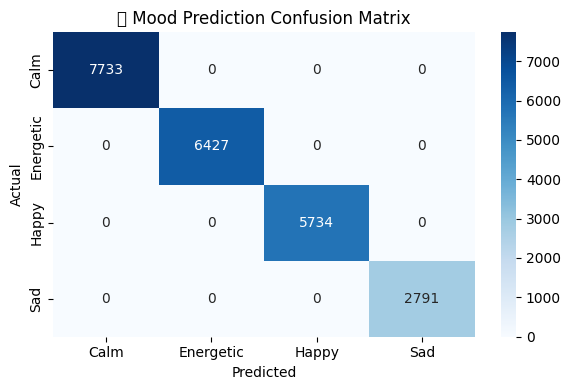

In [38]:
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train_scaled, y_train)

print("✅ Model training complete!")

y_pred = model.predict(X_test_scaled)

print("🔹 Accuracy:", accuracy_score(y_test, y_pred))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix Visualization
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("🎧 Mood Prediction Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(FIGURE_PATH + "confusion_matrix.png")
plt.show()

# Save Model & Encoders

In [39]:
joblib.dump(model, MODEL_PATH + "mood_model.pkl")
joblib.dump(scaler, MODEL_PATH + "scaler.pkl")
joblib.dump(le, MODEL_PATH + "label_encoder.pkl")

print("✅ Model, Scaler, and Encoder saved in 'models/' folder.")

✅ Model, Scaler, and Encoder saved in 'models/' folder.


# A Sample Prediction

In [40]:
sample = X_test.iloc[0:1]
scaled_sample = scaler.transform(sample)
pred = model.predict(scaled_sample)
predicted_mood = le.inverse_transform(pred)[0]

print("🎵 Sample Track Mood Prediction:", predicted_mood)

🎵 Sample Track Mood Prediction: Sad


# Mood Clustering & Visualization

In [41]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Select the same features for clustering
cluster_features = ["tempo", "energy", "loudness", "danceability", "valence"]
X_cluster = dataset[cluster_features]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Choose number of clusters (4 moods)
kmeans = KMeans(n_clusters=4, random_state=42)
dataset["cluster"] = kmeans.fit_predict(X_scaled)

print("✅ KMeans clustering complete!")
print(dataset["cluster"].value_counts())

✅ KMeans clustering complete!
cluster
2    42096
0    31775
1    30716
3     8835
Name: count, dtype: int64


# Visualize Clusters in 2D

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19956\696817363.py:17: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19956\696817363.py:18: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  plt.savefig(FIGURE_PATH + "mood_clusters.png")
d:\coding\PROJECTS\Mood_from_music\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


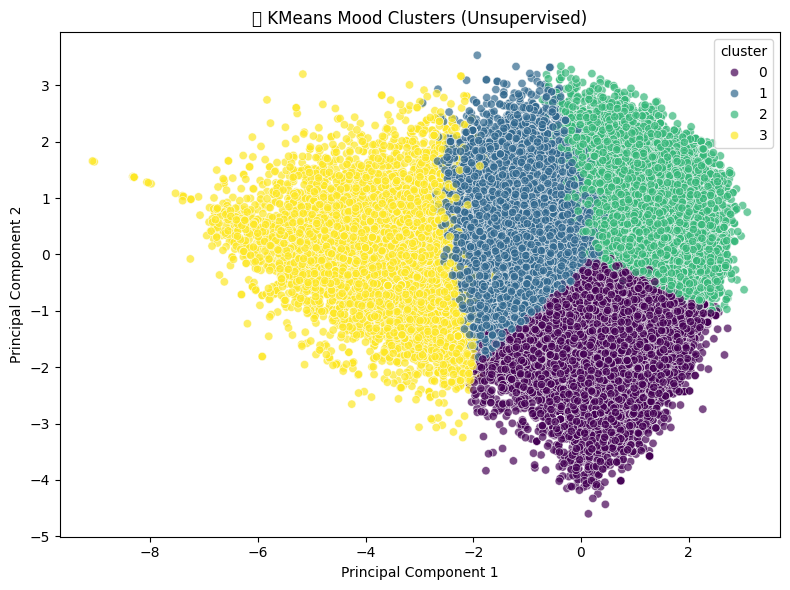

In [42]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_scaled)
dataset["pca1"] = reduced[:, 0]
dataset["pca2"] = reduced[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="pca1", y="pca2",
    hue="cluster",
    palette="viridis",
    data=dataset,
    alpha=0.7
)
plt.title("🎵 KMeans Mood Clusters (Unsupervised)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.tight_layout()
plt.savefig(FIGURE_PATH + "mood_clusters.png")
plt.show()

# Compare Cluster vs Actual Mood

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19956\3240876101.py:4: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19956\3240876101.py:5: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.savefig(FIGURE_PATH + "cluster_vs_mood.png")
d:\coding\PROJECTS\Mood_from_music\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


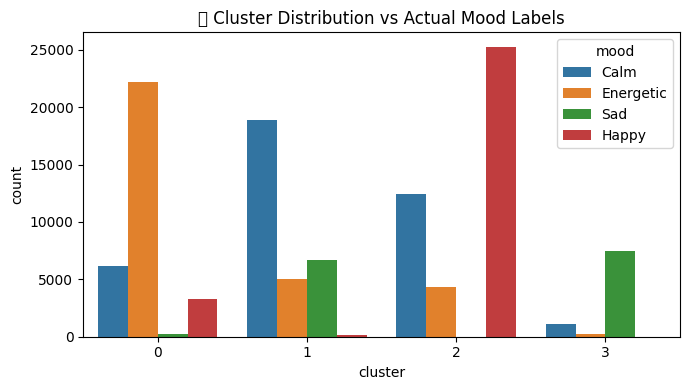

In [43]:
plt.figure(figsize=(7, 4))
sns.countplot(x="cluster", hue="mood", data=dataset)
plt.title("🧩 Cluster Distribution vs Actual Mood Labels")
plt.tight_layout()
plt.savefig(FIGURE_PATH + "cluster_vs_mood.png")
plt.show()